In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## helper functions


# reduce df to only taxa [index] that is present in a col: 'keep_col_name'
def trim_df_col(df, keep_col_name):
    df_results = df.copy()
    df_results = df_results[df_results[keep_col_name].notna()]
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

# reduce df to only taxa [index] with at least one val > thresh 
def trim_df_treshold(df, thresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results = df_results[df_results['max'] > thresh]
    df_results = df_results.drop(columns=['max'])
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

def trim_df_treshold_diff(df, maxthresh, minthresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results['min'] = df_results.min(axis=1)
    df_results = df_results[(df_results['min'] < minthresh)|(df_results['max'] > maxthresh)]
    df_results = df_results.drop(columns=['max', 'min'])
    return df_results

def extract_abundance(in_path, rank, in_col, out_col, taxa_col='name', multiplier=1):
    ext = in_path.split(".")[-1]
    if ext == "tsv":
        df_all = pd.read_csv(in_path, sep='\t')
    if ext == "csv":
        df_all = pd.read_csv(in_path)
    df = df_all[[taxa_col, in_col]].groupby(taxa_col).sum().reset_index()
    df = df.rename(columns={in_col:out_col, taxa_col:rank}).dropna()
    df[out_col] = df[out_col] * multiplier
    return df

def extract_abundance_kreport(in_path, rank, out_col):
    kreport_headers = ['clade_abundance', 'clade_counts', 'counts', 'rank', 'tax_id', 'name']
    df = pd.read_csv(in_path, header=None, names=kreport_headers, sep='\t')
    if rank == 'genus':
        df_rank = df[df['rank']=='G'].reset_index(drop=True)
    elif rank == 'species':
        df_rank = df[df['rank']=='S'].reset_index(drop=True)
    elif rank == 'family':
        df_rank = df[df['rank']=='F'].reset_index(drop=True)
    total_counts = sum(df_rank['clade_counts'])
    df_rank['clade_abundance'] = df_rank['clade_counts']/total_counts*100
    df_rank['name_stripped'] = df_rank['name'].apply(lambda x: x.strip())
    df_trimmed = df_rank[['name_stripped', 'clade_abundance']]
    return df_trimmed.rename(columns={'name_stripped':rank, 'clade_abundance':out_col})

def extract_abundance_qiime(path, rank):
    df_results = pd.read_csv(path, sep='\t', skiprows=[0])
    df_results = df_results.rename(columns={df_results.columns[1]:"abundance"})
    df_results[rank] = df_results["#OTU ID"].apply(lambda x: x.split(";")[-1])
    df_results = df_results[df_results[rank].apply(lambda x:x[0]==rank[0])]
    df_results[rank] = df_results[rank].apply(lambda x:x[3:])
    #total = df_results['abundance'].sum()
    df_results['abundance'] = df_results['abundance']*100
    return df_results[[rank,'abundance']].rename(columns={'abundance':'Qiime2'})

def extract_abundance_metamaps(path, rank):
    df_results = pd.read_csv(path, sep='\t')
    df_rank = df_results[df_results['AnalysisLevel']==rank]
    df_rank = df_rank[['Name','EMFrequency']].groupby('Name').sum().reset_index()
    df_rank = df_rank.rename(columns={'Name':rank, 'EMFrequency':'MetaMaps'}).dropna()
    df_rank['MetaMaps'] = df_rank['MetaMaps']*100
    return df_rank

def extract_abundance_nanoclust(nanoclust_path, rank):
    return extract_abundance(nanoclust_path, rank, 'rel_abundance', 'NanoCLUST', taxa_col='taxid', multiplier=100)

def extract_abundance_theoretical(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'theoretical', taxa_col=rank)

def extract_abundance_primary(in_path, rank, out_col):
    return extract_abundance(in_path, rank, 'abundance', out_col, taxa_col=rank, multiplier=100)

def extract_abundance_emu(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'Emu', taxa_col=rank, multiplier=100)

def extract_abundance_bracken(bracken_path, rank):
    return extract_abundance(bracken_path, rank, 'fraction_total_reads', 'Bracken', taxa_col='name', multiplier=100)

def extract_abundance_kraken(kraken_path, rank):
    return extract_abundance_kreport(kraken_path, rank, 'Kraken2')

def extract_abundance_centrifuge(kraken_path, rank):
    return extract_abundance_kreport(kraken_path, rank, 'Centrifuge')


# print L1 and L2 norm for all columns compared to col: 'compare_col_name'
def print_L1_L2(df, compare_col_name):
    df_results = df.copy().fillna(0)
    relative_truth = df_results[compare_col_name]
    df_results = df_results.drop(columns=[compare_col_name])
    df_results = df_results.sub(relative_truth, axis=0).fillna(0)
    df_results_L1 = df_results.applymap(lambda x: abs(x))
    L1 = df_results_L1.sum() * .01
    df_results_L2 = df_results.applymap(lambda x: (x**2))
    L2 = df_results_L2.sum().apply(lambda x: math.sqrt(x)) * .01
    print(f"L1:\n{L1.to_string()}\n")
    print(f"L2:\n{L2.to_string()}\n")
    
# print precision and recall stats for all columns compared to col: 'compare_col_name'
def print_precision_recall(df, compare_col_name):
    df_results = df.copy()
    df_results = df_results.replace(0,np.NaN)
    df_presence = df_results.notnull()
    df_counts = df_presence.sum()
    df_true_positive = df_presence[df_presence[compare_col_name]]
    true_positives = df_true_positive.sum()
    precision = true_positives/df_counts
    sensitivity = true_positives/df_counts[compare_col_name]
    stats = {}
    stats['true_positives'] = df_true_positive.sum()
    stats['false_positives'] = df_counts - true_positives
    stats['precision'] = precision
    stats['recall'] = sensitivity
    stats['f_score'] = 2*precision*sensitivity/(precision+sensitivity)
    display(pd.DataFrame(stats))
    print("\n")
    
def get_unclassified_percent_kreport(in_path, rank):
    total_reads = 4310093
    kreport_headers = ['clade_abundance', 'clade_counts', 'counts', 'rank', 'tax_id', 'name']
    df = pd.read_csv(in_path, header=None, names=kreport_headers, sep='\t')
    if rank == 'genus':
        df_rank = df[df['rank']=='G'].reset_index(drop=True)
    elif rank == 'species':
        df_rank = df[df['rank']=='S'].reset_index(drop=True)
    elif rank == 'family':
        df_rank = df[df['rank']=='F'].reset_index(drop=True)
    total_counts = sum(df_rank['clade_counts'])
    percent_unclassified = (total_reads - total_counts)/total_reads*100
    print(f"Kraken2: {percent_unclassified}%")
    
def get_unclassified_percent_bracken(in_path):
    total_reads = 4310093
    df_all = pd.read_csv(in_path, sep='\t')
    total_counts = sum(df_all['new_est_reads'])
    percent_unclassified = (total_reads - total_counts)/total_reads*100
    print(f"Bracken: {percent_unclassified}%")
    
def get_unclassified_percent_minimap(in_path, rank):
    total_reads = 4310093
    df = pd.read_csv(in_path, sep='\t')
    df_rank = df[df[rank].notna()]
    percent_unclassified = (total_reads - sum(df_rank['count']))/total_reads*100
    print(f"Minimap2: {percent_unclassified}%")
    
def get_unclassified_percent_emu(in_path, assigned_reads, rank):
    total_reads = 4310093
    df = pd.read_csv(in_path, sep='\t')
    df_rank = df[['abundance', rank]]
    total_ab = sum(df_rank.dropna()['abundance'])
    assigned_count = total_ab * assigned_reads
    percent_unclassified = (total_reads - assigned_count)/total_reads*100
    print(f"Emu: {percent_unclassified}%")

# Make absolute diff in relative abundance heatmaps for a given sample, sequencing type, and taxonomic rank.
def absolute_diff_heatmap(df, output_name):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    if 'unclassified' in df.index:
        df.drop(index=['unclassified'], inplace=True)
    if 'theoretical' in df.columns:
        df.rename(columns={'theoretical': 'truth'}, inplace=True)
    diffs_df = df.copy().fillna(0)
    for col in diffs_df.columns:
        if col != 'truth':
            diffs_df[col] = diffs_df[col] - diffs_df['truth']
    diffs_df.drop(columns=['truth'], inplace=True)

    _, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(diffs_df, yticklabels=1, xticklabels=1, cmap="RdBu_r", center=0, vmin=-10, vmax=10, square=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7,
                     box.height])
    plt.setp(ax.get_yticklabels(), fontsize=7)
    plt.setp(ax.get_xticklabels(), fontsize=7)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.subplots_adjust(left=0.35)
    plt.savefig(f"./results_heatmap/RDP/{output_name}.png")
    return diffs_df

def top_num_both_dfs(df1, df2, NUM_KEPT=20):
    df1_copy = df1.copy()
    df1_copy['max'] = df1_copy.max(axis=1)
    df2_copy = df2.copy()
    df2_copy['max'] = df2_copy.max(axis=1)
    df1_copy = df1_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    df2_copy = df2_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    joined_df = df1_copy.join(df2_copy, how='outer', lsuffix='1', rsuffix='2')
    joined_df['overall_max'] = joined_df.max(axis=1)
    joined_df = joined_df.sort_values(by='overall_max', ascending=False)
    all_indices = list(joined_df.index)
    filtered_indices = [index for index in all_indices if index in df1.index and index in df2.index]
    return sorted(filtered_indices[:NUM_KEPT])

def top_num_df(df, NUM_KEPT = 20):
    df_copy = df.copy()
    df_copy['max'] = df_copy.max(axis=1)
    df_copy = df_copy.sort_values(by='max', ascending=False)
    indices = list(df_copy.index)
    return sorted(indices[:NUM_KEPT])

def trim_df_keep_some(df, keep_these):
    df_copy = df.copy()
    df_copy = df_copy.loc[keep_these, :]
    df_copy.loc['other'] = 100 - df_copy.sum()
    return df_copy


## Simulated MBARC

unique species: 26
number of reads: 958,655

deep_simulator.sh -i reference -n read_number -B 2 -c 20 -o output_filename"

In [3]:
## MBARC results_quantitative - paths

# Nanopore truth - primary assignment to restricted db [minimap2]
mbarc_ncbi_theoretical_path = "./results_quantitative/truth/mbarc_ncbi_theoretical_rdp.csv"

mbarc_ncbi_emu_path = "./results_db_comp/RDP/Emu/mbarc_ncbi_rel-abundance.tsv"
mbarc_ncbi_kraken_path = "./results_db_comp/RDP/Kraken2/mbarc.kreport"
mbarc_ncbi_bracken_species_path = "./results_db_comp/RDP/Bracken/mbarc_species.tsv"
mbarc_ncbi_bracken_genus_path = "./results_db_comp/RDP/Bracken/mbarc_genus.tsv"
mbarc_ncbi_minimap_path = "./results_db_comp/RDP/minimap2/mbarc_primary_counts.tsv"

L1:
Emu         0.029023
Minimap2    0.066019
Kraken2     0.584144
Bracken     0.937994

L2:
Emu         0.020494
Minimap2    0.030545
Kraken2     0.143612
Bracken     0.240921



true_positives  false_positives  precision  recall   f_score
theoretical              24                0   1.000000    1.00  1.000000
Emu                      24                1   0.960000    1.00  0.979592
Minimap2                 24               29   0.452830    1.00  0.623377
Kraken2                  24              534   0.043011    1.00  0.082474
Bracken                  18              100   0.152542    0.75  0.253521

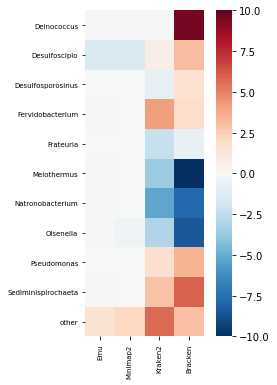

In [4]:
## MBARC Nanopore - Genus Level

mbarc_ncbi_theoretical_genus = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'genus')
mbarc_emu_genus = extract_abundance_emu(mbarc_ncbi_emu_path,'genus')
mbarc_kraken_genus = extract_abundance_kraken(mbarc_ncbi_kraken_path, 'genus')
mbarc_bracken_genus = extract_abundance_bracken(mbarc_ncbi_bracken_genus_path, 'genus')
mbarc_minimap_genus = extract_abundance_primary(mbarc_ncbi_minimap_path, 'genus', 'Minimap2')

df_results_mbarc_nanopore_genus = mbarc_ncbi_theoretical_genus
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_emu_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_minimap_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_kraken_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = pd.merge(df_results_mbarc_nanopore_genus, mbarc_bracken_genus, how='outer', on=['genus'])
df_results_mbarc_nanopore_genus = df_results_mbarc_nanopore_genus.set_index("genus")
df_results_mbarc_nanopore_genus.to_csv("./results_spreadsheets/RDP/mbarc_genus.tsv", sep='\t')

#df_results_mbarc_nanopore_genus_drop_thresh = trim_df_treshold(df_results_mbarc_nanopore_genus, 1)
#df_results_mbarc_nanopore_genus_drop_thresh = df_results_mbarc_nanopore_genus_drop_thresh.sort_index()
#df_results_mbarc_nanopore_genus_drop_thresh = df_results_mbarc_nanopore_genus_drop_thresh.reset_index()
#df_results_mbarc_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "MBARC Simulated Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_mbarc_mock_genus.jpg", bbox_inches='tight')

df_results_mbarc_genus_top20 = trim_df_keep_some(df_results_mbarc_nanopore_genus, top_num_df(df_results_mbarc_nanopore_genus, NUM_KEPT=10))
mbarc_genus_diff = absolute_diff_heatmap(df_results_mbarc_genus_top20, "mbarc_genus")

print_L1_L2(df_results_mbarc_nanopore_genus, 'theoretical')
print_precision_recall(df_results_mbarc_nanopore_genus, 'theoretical')

L1:
Emu         0.029174
Minimap2    0.119644
Kraken2     0.868696
Bracken     1.101469

L2:
Emu         0.020494
Minimap2    0.037736
Kraken2     0.215762
Bracken     0.282523



true_positives  false_positives  precision    recall   f_score
theoretical              26                0   1.000000  1.000000  1.000000
Emu                      26                3   0.896552  1.000000  0.945455
Minimap2                 26              400   0.061033  1.000000  0.115044
Kraken2                  22             2756   0.007919  0.846154  0.015692
Bracken                  18              174   0.093750  0.692308  0.165138

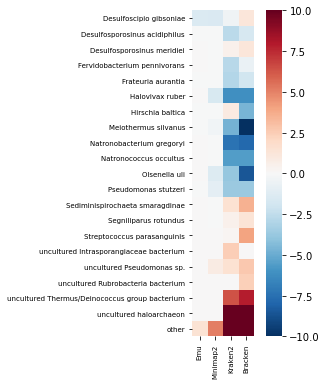

In [5]:
## MBARC Nanopore - species Level

mbarc_ncbi_theoretical_species = extract_abundance_theoretical(mbarc_ncbi_theoretical_path, 'species')
mbarc_emu_species = extract_abundance_emu(mbarc_ncbi_emu_path,'species')
mbarc_kraken_species = extract_abundance_kraken(mbarc_ncbi_kraken_path, 'species')
mbarc_bracken_species = extract_abundance_bracken(mbarc_ncbi_bracken_species_path, 'species')
mbarc_minimap_species = extract_abundance_primary(mbarc_ncbi_minimap_path, 'species', 'Minimap2')

df_results_mbarc_nanopore_species = mbarc_ncbi_theoretical_species
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_emu_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_minimap_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_kraken_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = pd.merge(df_results_mbarc_nanopore_species, mbarc_bracken_species, how='outer', on=['species'])
df_results_mbarc_nanopore_species = df_results_mbarc_nanopore_species.set_index("species")
df_results_mbarc_nanopore_species.to_csv("./results_spreadsheets/RDP/mbarc_species.tsv", sep='\t')

#df_results_mbarc_nanopore_species_drop_thresh = trim_df_treshold(df_results_mbarc_nanopore_species, 1)
#df_results_mbarc_nanopore_species_drop_thresh = df_results_mbarc_nanopore_species_drop_thresh.sort_index()
#df_results_mbarc_nanopore_species_drop_thresh = df_results_mbarc_nanopore_species_drop_thresh.reset_index()
#df_results_mbarc_nanopore_species_drop_thresh.plot.bar(x='species', title = "MBARC Simulated Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_mbarc_mock_species.jpg", bbox_inches='tight')

df_results_mbarc_species_top20 = trim_df_keep_some(df_results_mbarc_nanopore_species, top_num_df(df_results_mbarc_nanopore_species, NUM_KEPT=20))
mbarc_species_diff = absolute_diff_heatmap(df_results_mbarc_species_top20, "mbarc_species")

print_L1_L2(df_results_mbarc_nanopore_species, 'theoretical')
print_precision_recall(df_results_mbarc_nanopore_species, 'theoretical')

## Simulated CAMI2

unique species: 353  
number of reads: 4,310,093


In [6]:
## CAMI2 results_quantitative - paths

# Nanopore truth - primary assignment to restricted db [minimap2]
cami2_theoretical_path = "./results_quantitative/truth/cami2_theoretical_RDP.csv"

cami2_emu_path = "./results_db_comp/RDP/Emu/cami2_rel-abundance.tsv"
cami2_kraken_path = "./results_db_comp/RDP/Kraken2/cami2.kreport"
cami2_bracken_species_path = "./results_db_comp/RDP/Bracken/cami2_species.tsv"
cami2_bracken_genus_path = "./results_db_comp/RDP/Bracken/cami2_genus.tsv"
cami2_bracken_family_path = "./results_db_comp/RDP/Bracken/cami2_family.tsv"
cami2_minimap_path = "./results_db_comp/RDP/minimap2/cami2_primary_counts.tsv"


L1:
Emu         0.102471
Minimap2    0.114270
Kraken2     0.414909
Bracken     0.887097

L2:
Emu         0.044433
Minimap2    0.044333
Kraken2     0.120916
Bracken     0.242956



true_positives  false_positives  precision    recall   f_score
theoretical              72                0   1.000000  1.000000  1.000000
Emu                      65               16   0.802469  0.902778  0.849673
Minimap2                 71              277   0.204023  0.986111  0.338095
Kraken2                  71              474   0.130275  0.986111  0.230146
Bracken                  61              214   0.221818  0.847222  0.351585



Percent Unclassified:
Emu: 17.170061674585845%
Minimap2: 16.835553200360177%
Kraken2: 36.453784175886696%
Bracken: 34.51155230293175%


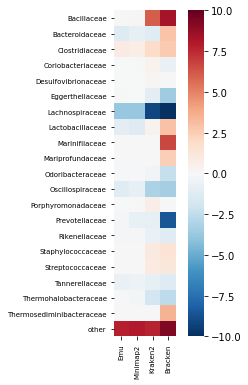

In [7]:
## cami2 Nanopore - family Level

cami2_theoretical_family = extract_abundance_theoretical(cami2_theoretical_path, 'family')
cami2_emu_family = extract_abundance_emu(cami2_emu_path,'family')
cami2_kraken_family = extract_abundance_kraken(cami2_kraken_path, 'family')
cami2_bracken_family = extract_abundance_bracken(cami2_bracken_family_path, 'family')
cami2_minimap_family = extract_abundance_primary(cami2_minimap_path, 'family', 'Minimap2')

df_results_cami2_nanopore_family = cami2_theoretical_family
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_emu_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_minimap_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_kraken_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = pd.merge(df_results_cami2_nanopore_family, cami2_bracken_family, how='outer', on=['family'])
df_results_cami2_nanopore_family = df_results_cami2_nanopore_family.set_index("family")
df_results_cami2_nanopore_family.to_csv("./results_spreadsheets/RDP/cami2_family.tsv", sep='\t')

df_results_cami2_family_top20 = trim_df_keep_some(df_results_cami2_nanopore_family, top_num_df(df_results_cami2_nanopore_family))
cami2_family_diff = absolute_diff_heatmap(df_results_cami2_family_top20, "cami2_family")

print_L1_L2(df_results_cami2_nanopore_family, 'theoretical')
print_precision_recall(df_results_cami2_nanopore_family, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emu_path, 3899317, 'family')
get_unclassified_percent_minimap(cami2_minimap_path, 'family')
get_unclassified_percent_kreport(cami2_kraken_path, 'family')
get_unclassified_percent_bracken(cami2_bracken_family_path)


L1:
Emu         0.136865
Minimap2    0.152097
Kraken2     0.576624
Bracken     1.009654

L2:
Emu         0.025556
Minimap2    0.027760
Kraken2     0.086041
Bracken     0.158764



true_positives  false_positives  precision    recall   f_score
theoretical             190                0   1.000000  1.000000  1.000000
Emu                     163               43   0.791262  0.857895  0.823232
Minimap2                184              995   0.156064  0.968421  0.268809
Kraken2                 175             2058   0.078370  0.921053  0.144449
Bracken                 107              543   0.164615  0.563158  0.254762



Percent Unclassified:
Emu: 19.471672761615608%
Minimap2: 19.896693644429483%
Kraken2: 45.48860082601466%
Bracken: 34.92530207584848%


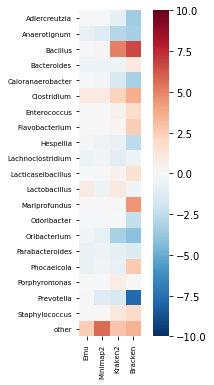

In [8]:
## cami2 Nanopore - genus Level

cami2_theoretical_genus = extract_abundance_theoretical(cami2_theoretical_path, 'genus')
cami2_emu_genus = extract_abundance_emu(cami2_emu_path,'genus')
cami2_kraken_genus = extract_abundance_kraken(cami2_kraken_path, 'genus')
cami2_bracken_genus = extract_abundance_bracken(cami2_bracken_genus_path, 'genus')
cami2_minimap_genus = extract_abundance_primary(cami2_minimap_path, 'genus', 'Minimap2')

df_results_cami2_nanopore_genus = cami2_theoretical_genus
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_emu_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_minimap_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_kraken_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = pd.merge(df_results_cami2_nanopore_genus, cami2_bracken_genus, how='outer', on=['genus'])
df_results_cami2_nanopore_genus = df_results_cami2_nanopore_genus.set_index("genus")
df_results_cami2_nanopore_genus.to_csv("./results_spreadsheets/RDP/cami2_genus.tsv", sep='\t')

df_results_cami2_genus_top20 = trim_df_keep_some(df_results_cami2_nanopore_genus, top_num_df(df_results_cami2_nanopore_genus))
cami2_genus_diff = absolute_diff_heatmap(df_results_cami2_genus_top20, "cami2_genus")

print_L1_L2(df_results_cami2_nanopore_genus, 'theoretical')
print_precision_recall(df_results_cami2_nanopore_genus, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emu_path, 3899317, 'genus')
get_unclassified_percent_minimap(cami2_minimap_path, 'genus')
get_unclassified_percent_kreport(cami2_kraken_path, 'genus')
get_unclassified_percent_bracken(cami2_bracken_genus_path)


L1:
Emu         0.415996
Minimap2    0.560020
Kraken2     1.481340
Bracken     1.694453

L2:
Emu         0.079646
Minimap2    0.069735
Kraken2     0.198289
Bracken     0.218942



true_positives  false_positives  precision    recall   f_score
theoretical             345                0   1.000000  1.000000  1.000000
Emu                     290              373   0.437406  0.840580  0.575397
Minimap2                331            12512   0.025773  0.959420  0.050197
Kraken2                 295            30764   0.009498  0.855072  0.018787
Bracken                 153             1831   0.077117  0.443478  0.131387



Percent Unclassified:
Emu: 9.530560013451298%
Minimap2: 9.5319752961247%
Kraken2: 41.56996148342971%
Bracken: 35.0789414520754%


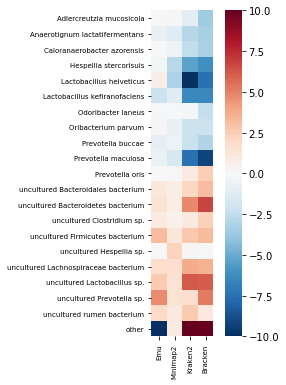

In [9]:
## cami2 Nanopore - species Level

cami2_theoretical_species = extract_abundance_theoretical(cami2_theoretical_path, 'species')
cami2_emu_species = extract_abundance_emu(cami2_emu_path,'species')
cami2_kraken_species = extract_abundance_kraken(cami2_kraken_path, 'species')
cami2_bracken_species = extract_abundance_bracken(cami2_bracken_species_path, 'species')
cami2_minimap_species = extract_abundance_primary(cami2_minimap_path, 'species', 'Minimap2')

df_results_cami2_nanopore_species = cami2_theoretical_species
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_emu_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_minimap_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_kraken_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = pd.merge(df_results_cami2_nanopore_species, cami2_bracken_species, how='outer', on=['species'])
df_results_cami2_nanopore_species = df_results_cami2_nanopore_species.set_index("species")
df_results_cami2_nanopore_species.to_csv("./results_spreadsheets/RDP/cami2_species.tsv", sep='\t')

df_results_cami2_species_top20 = trim_df_keep_some(df_results_cami2_nanopore_species, top_num_df(df_results_cami2_nanopore_species))
cami2_species_diff = absolute_diff_heatmap(df_results_cami2_species_top20, "cami2_species")

print_L1_L2(df_results_cami2_nanopore_species, 'theoretical')
print_precision_recall(df_results_cami2_nanopore_species, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emu_path, 3899317, 'species')
get_unclassified_percent_minimap(cami2_minimap_path, 'species')
get_unclassified_percent_kreport(cami2_kraken_path, 'species')
get_unclassified_percent_bracken(cami2_bracken_species_path)

## Mock - ZYMOBIOMICS [D3603] 

source: https://www.mdpi.com/1422-0067/21/1/298/htm  
ENA project archieve: https://www.ebi.ac.uk/ena/browser/view/PRJNA587452


#### Nanopore
acc: SRR10391201  
#reads: 1,108,690 


#### Illumina (v4-6)
acc: SRR10391187   
#reads: 390,381


In [10]:
## ZymoBIOMICS results_quantitative - paths

zymo_theoretical_path = "./results_quantitative/truth/zymo_theoretical.csv"
zymo_nanopore_truth_path = "./results_quantitative/truth/zymo_nanopore_assembled_minimap_primary.tsv"
zymo_nanopore_emu_path = "./results_db_comp/RDP/Emu/zymo_nanopore_rel-abundance-threshold-0.0001.tsv"
zymo_nanopore_kraken_path = "./results_db_comp/RDP/Kraken2/zymo.kreport"
zymo_nanopore_bracken_species_path = "./results_db_comp/RDP/Bracken/zymo_species.tsv"
zymo_nanopore_bracken_genus_path = "./results_db_comp/RDP/Bracken/zymo_genus.tsv"
zymo_nanopore_minimap_path = "./results_db_comp/RDP/minimap2/zymo_primary_counts.tsv"


L1:
Emu         0.006739
Minimap2    0.075770
Kraken2     0.614895
Bracken     0.563107

L2:
Emu         0.002410
Minimap2    0.028181
Kraken2     0.206147
Bracken     0.186854

.01% THRESHOLD



true_positives  false_positives  precision  recall   f_score
truth                  8                0   1.000000     1.0  1.000000
Emu                    8                3   0.727273     1.0  0.842105
Minimap2               8               14   0.363636     1.0  0.533333
Kraken2                8               95   0.077670     1.0  0.144144
Bracken                8               96   0.076923     1.0  0.142857

'The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)'

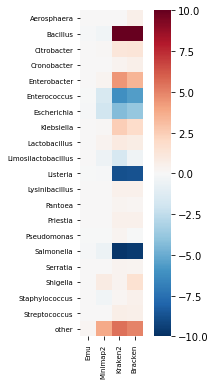

In [11]:
## ZymoBIOMICS Nanopore - Genus Level

zymo_truth_genus = extract_abundance_primary(zymo_nanopore_truth_path, 'genus', 'truth')
zymo_emu_genus = extract_abundance_emu(zymo_nanopore_emu_path, 'genus')
zymo_kraken_genus = extract_abundance_kraken(zymo_nanopore_kraken_path, 'genus')
zymo_bracken_genus = extract_abundance_bracken(zymo_nanopore_bracken_genus_path, 'genus')
zymo_minimap_genus = extract_abundance_primary(zymo_nanopore_minimap_path, 'genus', 'Minimap2')

df_results_zymo_nanopore_genus = zymo_truth_genus
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_emu_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_minimap_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_kraken_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = pd.merge(df_results_zymo_nanopore_genus, zymo_bracken_genus, how='outer', on=['genus'])
df_results_zymo_nanopore_genus = df_results_zymo_nanopore_genus.set_index("genus")
df_results_zymo_nanopore_genus.to_csv("./results_spreadsheets/RDP/zymo_nanopore_genus.tsv", sep='\t')

#df_results_zymo_nanopore_genus_drop_thresh = trim_df_treshold(df_results_zymo_nanopore_genus, 1)
#df_results_zymo_nanopore_genus_drop_thresh = df_results_zymo_nanopore_genus_drop_thresh.sort_index()
#df_results_zymo_nanopore_genus_drop_thresh = df_results_zymo_nanopore_genus_drop_thresh.reset_index()
#df_results_zymo_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "ZymoBIOMICS Mock Nanopore Abundances - Genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_genus.jpg", bbox_inches='tight')

df_results_zymo_nanopore_genus_top20 = trim_df_keep_some(df_results_zymo_nanopore_genus, top_num_df(df_results_zymo_nanopore_genus))
zymo_nanopore_genus_diff = absolute_diff_heatmap(df_results_zymo_nanopore_genus_top20, "zymo_nanopore_genus")


print_L1_L2(df_results_zymo_nanopore_genus, 'truth')
print(".01% THRESHOLD\n")
df_results_zymo_nanopore_genus[df_results_zymo_nanopore_genus<.01]=0
print_precision_recall(df_results_zymo_nanopore_genus, 'truth')

"The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)"


L1:
Emu         0.196566
Minimap2    0.500227
Kraken2     1.227394
Bracken     1.027950

L2:
Emu         0.101426
Minimap2    0.142189
Kraken2     0.292206
Bracken     0.275500

.01% THRESHOLD



true_positives  false_positives  precision  recall   f_score
truth                  8                0   1.000000     1.0  1.000000
Emu                    8               43   0.156863     1.0  0.271186
Minimap2               8              231   0.033473     1.0  0.064777
Kraken2                8              561   0.014060     1.0  0.027730
Bracken                8              270   0.028777     1.0  0.055944

'The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)'

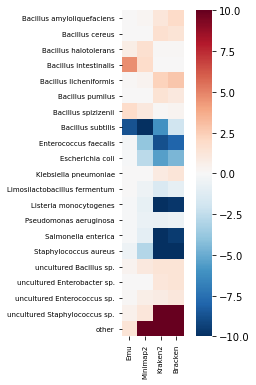

In [12]:
## ZymoBIOMICS Nanopore - species Level

zymo_truth_species = extract_abundance_primary(zymo_nanopore_truth_path, 'species', 'truth')
zymo_emu_species = extract_abundance_emu(zymo_nanopore_emu_path, 'species')
zymo_kraken_species = extract_abundance_kraken(zymo_nanopore_kraken_path, 'species')
zymo_bracken_species = extract_abundance_bracken(zymo_nanopore_bracken_species_path, 'species')
zymo_minimap_species = extract_abundance_primary(zymo_nanopore_minimap_path, 'species', 'Minimap2')

df_results_zymo_nanopore_species = zymo_truth_species
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_emu_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_minimap_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_kraken_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = pd.merge(df_results_zymo_nanopore_species, zymo_bracken_species, how='outer', on=['species'])
df_results_zymo_nanopore_species = df_results_zymo_nanopore_species.set_index("species")
df_results_zymo_nanopore_species.to_csv("./results_spreadsheets/RDP/zymo_nanopore_species.tsv", sep='\t')

#df_results_zymo_nanopore_species_drop_thresh = trim_df_treshold(df_results_zymo_nanopore_species, 1)
#df_results_zymo_nanopore_species_drop_thresh = df_results_zymo_nanopore_species_drop_thresh.sort_index()
#df_results_zymo_nanopore_species_drop_thresh = df_results_zymo_nanopore_species_drop_thresh.reset_index()
#df_results_zymo_nanopore_species_drop_thresh.plot.bar(x='species', title = "ZymoBIOMICS Mock Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_zymo_mock_species.jpg", bbox_inches='tight')

df_results_zymo_nanopore_species_top20 = trim_df_keep_some(df_results_zymo_nanopore_species, top_num_df(df_results_zymo_nanopore_species))
zymo_nanopore_species_diff = absolute_diff_heatmap(df_results_zymo_nanopore_species_top20, "zymo_nanopore_species")


print_L1_L2(df_results_zymo_nanopore_species, 'truth')
print(".01% THRESHOLD\n")
df_results_zymo_nanopore_species[df_results_zymo_nanopore_species<.01]=0
print_precision_recall(df_results_zymo_nanopore_species, 'truth')

"The microbial standard is accurately characterized and contains negligible impurities (< 0.01%)"


## Synthetic - Tor  


#### Nanopore
#reads: 302,309


In [13]:
## Tor results_quantitative - paths

tor_theoretical_path = "./results_quantitative/truth/tor_theoretical.csv"
tor_nanopore_truth_path = "./results_quantitative/truth/tor_nanopore_restricted_efaecalis_minimap_primary.tsv"
tor_nanopore_emu_path = "./results_db_comp/RDP/Emu/tor_nanopore_rel-abundance.tsv"
tor_nanopore_kraken_path = "./results_db_comp/RDP/Kraken2/tor.kreport"
tor_nanopore_bracken_species_path = "./results_db_comp/RDP/Bracken/tor_species.tsv"
tor_nanopore_bracken_genus_path = "./results_db_comp/RDP/Bracken/tor_genus.tsv"
tor_nanopore_minimap_path = "./results_db_comp/RDP/minimap2/tor_primary_counts.tsv"


L1:
Emu         0.141229
Minimap2    0.315764
Kraken2     1.076402
Bracken     1.095186

L2:
Emu         0.063462
Minimap2    0.123328
Kraken2     0.310643
Bracken     0.323868



true_positives  false_positives  precision    recall   f_score
truth                 18                0   1.000000  1.000000  1.000000
Emu                   16                8   0.666667  0.888889  0.761905
Minimap2              17              103   0.141667  0.944444  0.246377
Kraken2               16              658   0.023739  0.888889  0.046243
Bracken               15              179   0.077320  0.833333  0.141509



0.0033797257014620695 THRESHOLD



true_positives  false_positives  precision    recall   f_score
truth                 18                0   1.000000  1.000000  1.000000
Emu                   16                8   0.666667  0.888889  0.761905
Minimap2              17               20   0.459459  0.944444  0.618182
Kraken2               15              255   0.055556  0.833333  0.104167
Bracken               14              159   0.080925  0.777778  0.146597



L1/L2 without Romboutsia
L1:
Emu         0.137882
Minimap2    0.256269
Kraken2     0.956368
Bracken     0.973595

L2:
Emu         0.063374
Minimap2    0.108029
Kraken2     0.286515
Bracken     0.300177



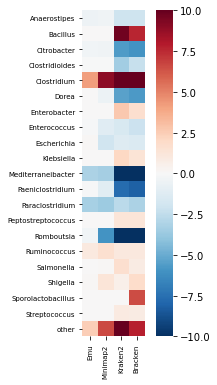

In [14]:
## Tor Nanopore - genus Level

tor_nanopore_truth_genus = extract_abundance_primary(tor_nanopore_truth_path, 'genus', 'truth')
tor_nanopore_emu_genus = extract_abundance_emu(tor_nanopore_emu_path, 'genus')
tor_nanopore_kraken_genus = extract_abundance_kraken(tor_nanopore_kraken_path, 'genus')
tor_nanopore_bracken_genus = extract_abundance_bracken(tor_nanopore_bracken_genus_path, 'genus')
tor_nanopore_minimap_genus = extract_abundance_primary(tor_nanopore_minimap_path, 'genus', 'Minimap2')

df_results_tor_nanopore_genus = tor_nanopore_truth_genus
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_emu_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_minimap_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_kraken_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = pd.merge(df_results_tor_nanopore_genus, tor_nanopore_bracken_genus, how='outer', on=['genus'])
df_results_tor_nanopore_genus = df_results_tor_nanopore_genus.set_index("genus")
df_results_tor_nanopore_genus.to_csv("./results_spreadsheets/RDP/tor_nanopore_genus.tsv", sep='\t')

#df_results_tor_nanopore_genus_drop_thresh = trim_df_treshold(df_results_tor_nanopore_genus, 2)
#df_results_tor_nanopore_genus_drop_thresh = trim_df_col(df_results_tor_nanopore_genus, 'truth')
#df_results_tor_nanopore_genus_drop_thresh = df_results_tor_nanopore_genus_drop_thresh.sort_index()
#df_results_tor_nanopore_genus_drop_thresh = df_results_tor_nanopore_genus_drop_thresh.reset_index()
#df_results_tor_nanopore_genus_drop_thresh.plot.bar(x='genus', title = "Tor Synthetic Nanopore Abundances - genus Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_genus.jpg", bbox_inches='tight')

df_results_tor_nanopore_genus_top20 = trim_df_keep_some(df_results_tor_nanopore_genus, top_num_df(df_results_tor_nanopore_genus))
tor_nanopore_genus_diff = absolute_diff_heatmap(df_results_tor_nanopore_genus_top20, "tor_nanopore_genus")

print_L1_L2(df_results_tor_nanopore_genus, 'truth')
print_precision_recall(df_results_tor_nanopore_genus, 'truth')

thresh = 10/295882*100
print(f"{thresh} THRESHOLD\n")
df_results_tor_nanopore_genus_copy = df_results_tor_nanopore_genus.copy()
df_results_tor_nanopore_genus_copy[df_results_tor_nanopore_genus_copy<=thresh]=0
#df_results_tor_nanopore_genus_copy['truth'] = df_results_tor_nanopore_genus['truth']
print_precision_recall(df_results_tor_nanopore_genus_copy, 'truth')

## L1/L2 without Romboutsia
df_results_tor_nanopore_genus_drop_romb = df_results_tor_nanopore_genus.reset_index()
df_results_tor_nanopore_genus_drop_romb['genus'] = df_results_tor_nanopore_genus_drop_romb['genus'].apply(lambda x: x.split(" ")[0])
df_results_tor_nanopore_genus_drop_romb = df_results_tor_nanopore_genus_drop_romb[df_results_tor_nanopore_genus_drop_romb['genus']!='Romboutsia']
df_results_tor_nanopore_genus_drop_romb = df_results_tor_nanopore_genus_drop_romb.set_index("genus")

print("L1/L2 without Romboutsia")
print_L1_L2(df_results_tor_nanopore_genus_drop_romb, 'truth')


L1:
Emu         0.466571
Minimap2    0.667645
Kraken2     1.663142
Bracken     1.585230

L2:
Emu         0.186976
Minimap2    0.179976
Kraken2     0.350152
Bracken     0.377105



true_positives  false_positives  precision  recall   f_score
truth                 20                0   1.000000    1.00  1.000000
Emu                   16               51   0.238806    0.80  0.367816
Minimap2              18             1177   0.015063    0.90  0.029630
Kraken2               13             5772   0.002247    0.65  0.004479
Bracken               10              430   0.022727    0.50  0.043478



0.0033797257014620695 THRESHOLD



true_positives  false_positives  precision    recall   f_score
truth                 19                0   1.000000  1.000000  1.000000
Emu                   16               51   0.238806  0.842105  0.372093
Minimap2              17              272   0.058824  0.894737  0.110390
Kraken2               12             1223   0.009717  0.631579  0.019139
Bracken               10              408   0.023923  0.526316  0.045767



L1/L2 without Romboutsia
L1:
Emu         0.226396
Minimap2    0.483639
Kraken2     1.540475
Bracken     1.463289

L2:
Emu         0.078182
Minimap2    0.117078
Kraken2     0.328299
Bracken     0.356907



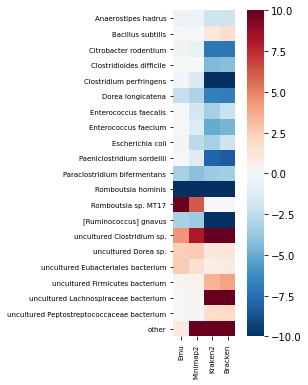

In [15]:
## Tor Nanopore - species Level

tor_nanopore_truth_species = extract_abundance_primary(tor_nanopore_truth_path, 'species', 'truth')
tor_nanopore_emu_species = extract_abundance_emu(tor_nanopore_emu_path, 'species')
tor_nanopore_kraken_species = extract_abundance_kraken(tor_nanopore_kraken_path, 'species')
tor_nanopore_bracken_species = extract_abundance_bracken(tor_nanopore_bracken_species_path, 'species')
tor_nanopore_minimap_species = extract_abundance_primary(tor_nanopore_minimap_path, 'species', 'Minimap2')

df_results_tor_nanopore_species = tor_nanopore_truth_species
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_emu_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_minimap_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_kraken_species, how='outer', on=['species'])
df_results_tor_nanopore_species = pd.merge(df_results_tor_nanopore_species, tor_nanopore_bracken_species, how='outer', on=['species'])
df_results_tor_nanopore_species = df_results_tor_nanopore_species.set_index("species")
df_results_tor_nanopore_species.to_csv("./results_spreadsheets/RDP/tor_nanopore_species.tsv", sep='\t')

#df_results_tor_nanopore_species_drop_thresh = trim_df_treshold(df_results_tor_nanopore_species, 2)
#df_results_tor_nanopore_species_drop_thresh = trim_df_col(df_results_tor_nanopore_species, 'truth')
#df_results_tor_nanopore_species_drop_thresh = df_results_tor_nanopore_species_drop_thresh.sort_index()
#df_results_tor_nanopore_species_drop_thresh = df_results_tor_nanopore_species_drop_thresh.reset_index()
#df_results_tor_nanopore_species_drop_thresh.plot.bar(x='species', title = "Tor Synthetic Nanopore Abundances - species Level",ylabel="relative abundance (%)").legend(loc='center left',bbox_to_anchor=(1.0, 0.8)).get_figure()#.savefig("/Users/kcurry/Desktop/EM_results_tor_mock_species.jpg", bbox_inches='tight')

df_results_tor_nanopore_species_top20 = trim_df_keep_some(df_results_tor_nanopore_species, top_num_df(df_results_tor_nanopore_species))
tor_nanopore_species_diff = absolute_diff_heatmap(df_results_tor_nanopore_species_top20, "tor_nanopore_species")

print_L1_L2(df_results_tor_nanopore_species, 'truth')
print_precision_recall(df_results_tor_nanopore_species, 'truth')

thresh = 10/295882*100
print(f"{thresh} THRESHOLD\n")
df_results_tor_nanopore_species_copy = df_results_tor_nanopore_species.copy()
df_results_tor_nanopore_species_copy[df_results_tor_nanopore_species_copy<=thresh]=0
#df_results_tor_nanopore_species_copy['truth'] = df_results_tor_nanopore_species['truth']
print_precision_recall(df_results_tor_nanopore_species_copy, 'truth')

## L1/L2 without Romboutsia
df_results_tor_nanopore_species_drop_romb = df_results_tor_nanopore_species.reset_index()
df_results_tor_nanopore_species_drop_romb['species'] = df_results_tor_nanopore_species_drop_romb['species'].apply(lambda x: x.split(" ")[0])
df_results_tor_nanopore_species_drop_romb = df_results_tor_nanopore_species_drop_romb[df_results_tor_nanopore_species_drop_romb['species']!='Romboutsia']
df_results_tor_nanopore_species_drop_romb = df_results_tor_nanopore_species_drop_romb.set_index("species")

print("L1/L2 without Romboutsia")
print_L1_L2(df_results_tor_nanopore_species_drop_romb, 'truth')


## EXTRA SCRIPTS

In [16]:
#map_arc_path = "/Users/kcurry/emu_dir/emu/db_RDP/rdp_seq2taxid_arc.tsv"
#map_bac_path = "/Users/kcurry/emu_dir/emu/db_RDP/rdp_seq2taxid_bac.tsv"
#unmapped_path = "/Users/kcurry/emu_dir/emu/db_RDP/unmapped_rdpnames.tsv"

#arc_df = pd.read_csv(map_arc_path, sep='\t', dtype=str)[['rdpname','taxid']]
#bac_df = pd.read_csv(map_bac_path, sep='\t', dtype=str, names=['rdpname','taxid'])
#unmapped_df = pd.read_csv(unmapped_path, sep='\t', dtype=str, names=['rdpname'])
#tax_id_bac_remove = ['77133', '155900']
#tax_id_arc_remove = ['115547', '155900']
#df_arc_drop_taxa = arc_df[~arc_df['taxid'].isin(tax_id_arc_remove)]
#df_bac_drop_taxa = bac_df[~bac_df['taxid'].isin(tax_id_bac_remove)]
#df = pd.concat([df_arc_drop_taxa,df_bac_drop_taxa])
#df_mapping = df[~df['rdpname'].isin(unmapped_df['rdpname'])]

#df_mapping.to_csv("/Users/kcurry/emu_dir/emu/db_RDP/seq2tax.map", sep='\t', index=False, header=False)